In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import pandas as pd

# Load the cleaned datasets
df_sales = pd.read_csv('../data/cleaned/Cleaned_Sales.csv')
df_products = pd.read_csv('../data/cleaned/Cleaned_Products.csv')
df_subcat = pd.read_csv('../data/cleaned/Cleaned_Product_Subcategories.csv')

# 1. Join logic
df_merged = df_sales[['OrderDate', 'StockDate', 'OrderQuantity', 'ProductKey']].merge(
    df_products[['ProductKey', 'ProductSubcategoryKey']], 
    on='ProductKey', 
    how='left'
).merge(
    df_subcat[['ProductSubcategoryKey', 'SubcategoryName']], 
    on='ProductSubcategoryKey', 
    how='left'
)

# 2. Correct Date Parsing (One pass with dayfirst=True)
df_merged['OrderDate'] = pd.to_datetime(df_merged['OrderDate'], dayfirst=True)
df_merged['StockDate'] = pd.to_datetime(df_merged['StockDate'], dayfirst=True)

# 3. Filter and Calculate Min StockDate
# Use a Timestamp object for comparison to avoid TypeErrors
cutoff_date = pd.to_datetime('2016-08-01')
df_sales_filtered = df_merged[df_merged['OrderDate'] >= cutoff_date].copy()

min_stock_date = df_merged['StockDate'].min()

In [5]:
# 4. Create the Dense Grid (Cartesian Product)
# Create a range of all dates from the cutoff to the max date in data
all_dates = pd.date_range(start=df_sales_filtered['OrderDate'].min(), 
                          end=df_sales_filtered['OrderDate'].max(), 
                          freq='D')

# Get all unique subcategory names
all_subcats = df_subcat['SubcategoryName'].unique()

# Create the skeleton dataframe
grid = pd.MultiIndex.from_product([all_dates, all_subcats], 
                                  names=['OrderDate', 'SubcategoryName'])
df_grid = pd.DataFrame(index=grid).reset_index()

# 5. Aggregate Sales and Merge
# Group sales by date and subcategory to sum quantities
df_daily_sales = df_sales_filtered.groupby(['OrderDate', 'SubcategoryName'], as_index=False).agg({
    'OrderQuantity': 'sum',
    'StockDate': 'first'
})

# Merge the grid with actual sales
df_final = pd.merge(df_grid, df_daily_sales, on=['OrderDate', 'SubcategoryName'], how='left')

# 6. Fill Missing Values
# If no sale occurred, Quantity is 0
df_final['OrderQuantity'] = df_final['OrderQuantity'].fillna(0)

# For items not sold, use the global Minimum StockDate calculated earlier
df_final['StockDate'] = df_final['StockDate'].fillna(min_stock_date)

# Display result
print(f"Final Dataframe Shape: {df_final.shape}")

Final Dataframe Shape: (12358, 4)


+ splitting the data by dead items / hot items

In [7]:
# 1. Aggregate metrics per Subcategory
route_metrics = df_final.groupby('SubcategoryName').agg(
    TotalSales=('OrderQuantity', 'sum'),
    ZeroDays=('OrderQuantity', lambda x: (x == 0).sum()),
    TotalDays=('OrderQuantity', 'count'),
    FirstStock=('StockDate', 'min'),
    LastDate=('OrderDate', 'max')
).reset_index()

# 2. Calculate Velocity (Exposure Adjustment)
# Days since stocked = (Max Date - Stock Date)
route_metrics['DaysSinceStocked'] = (route_metrics['LastDate'] - route_metrics['FirstStock']).dt.days + 1
route_metrics['DailyVelocity'] = route_metrics['TotalSales'] / route_metrics['DaysSinceStocked']

# 3. Define the 99% Velocity Threshold (Scientific robustness)
velocity_threshold = route_metrics['DailyVelocity'].quantile(0.99)
route_metrics['ZeroRatio'] = route_metrics['ZeroDays'] / route_metrics['TotalDays']

# 4. Define Routing Function
def determine_route(row):
    # Rule: If item is in the top 1% of velocity, force to AutoARIMA (Instant Success)
    if row['DailyVelocity'] >= velocity_threshold:
        return 'AutoARIMA'
    # Rule: Low Zero-Ratio (Stable)
    if row['ZeroRatio'] < 0.20:
        return 'AutoARIMA'
    # Rule: Moderate Zero-Ratio (Intermittent)
    elif row['ZeroRatio'] < 0.60:
        return 'Prophet'
    # Rule: High Zero-Ratio (Sparsely sold)
    else:
        return 'ColdStart'

route_metrics['ModelRoute'] = route_metrics.apply(determine_route, axis=1)

In [8]:
# Create a mapping dictionary
route_map = route_metrics.set_index('SubcategoryName')['ModelRoute'].to_dict()

# Map the route back to the original dense dataframe
df_final['TargetModel'] = df_final['SubcategoryName'].map(route_map)

# Create the 3 separate dataframes
arima_df = df_final[df_final['TargetModel'] == 'AutoARIMA'].copy()
prophet_df = df_final[df_final['TargetModel'] == 'Prophet'].copy()
cold_start_df = df_final[df_final['TargetModel'] == 'ColdStart'].copy()

# Summary Output
print(f"AutoARIMA Subcategories: {arima_df['SubcategoryName'].nunique()}")
print(f"Prophet Subcategories: {prophet_df['SubcategoryName'].nunique()}")
print(f"Cold Start Subcategories: {cold_start_df['SubcategoryName'].nunique()}")

AutoARIMA Subcategories: 6
Prophet Subcategories: 11
Cold Start Subcategories: 20


### Model Selection

In [10]:
# Function to split while preserving daily item density
def time_series_split(df, days_test=30):
    max_date = df['OrderDate'].max()
    split_date = max_date - pd.Timedelta(days=days_test)
    
    train = df[df['OrderDate'] <= split_date].copy()
    test = df[df['OrderDate'] > split_date].copy()
    return train, test

# Apply split to both dataframes
arima_train, arima_test = time_series_split(arima_df)
prophet_train, prophet_test = time_series_split(prophet_df)

In [12]:
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import numpy as np

def calculate_smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-10))

arima_metrics = []

for subcat in arima_train['SubcategoryName'].unique():
    # Filter for subcategory
    s_train = arima_train[arima_train['SubcategoryName'] == subcat].set_index('OrderDate')['OrderQuantity']
    s_test = arima_test[arima_test['SubcategoryName'] == subcat].set_index('OrderDate')['OrderQuantity']
    
    # Fit AutoARIMA
    model = auto_arima(s_train, seasonal=True, m=7, suppress_warnings=True, error_action="ignore")
    preds = model.predict(n_periods=len(s_test))
    
    # Evaluate
    rmse = np.sqrt(mean_squared_error(s_test, preds))
    smape = calculate_smape(s_test, preds)
    arima_metrics.append({'Subcategory': subcat, 'RMSE': rmse, 'sMAPE': smape})

arima_results_df = pd.DataFrame(arima_metrics)

+ prophet

In [14]:
from prophet import Prophet

prophet_metrics = []

for subcat in prophet_train['SubcategoryName'].unique():
    # Prepare data
    p_train = prophet_train[prophet_train['SubcategoryName'] == subcat][['OrderDate', 'OrderQuantity']].rename(columns={'OrderDate': 'ds', 'OrderQuantity': 'y'})
    p_test = prophet_test[prophet_test['SubcategoryName'] == subcat][['OrderDate', 'OrderQuantity']].rename(columns={'OrderDate': 'ds', 'OrderQuantity': 'y'})
    
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model.add_country_holidays(country_name='US')
    
    # Add Custom Events (Payday: 15th and End of Month)
    p_train['is_payday'] = p_train['ds'].dt.day.isin([15, 30])
    model.add_regressor('is_payday')
    
    model.fit(p_train)
    
    # Forecast
    future = p_test[['ds']].copy()
    future['is_payday'] = future['ds'].dt.day.isin([15, 30])
    forecast = model.predict(future)
    
    # Evaluate
    rmse = np.sqrt(mean_squared_error(p_test['y'], forecast['yhat']))
    smape = calculate_smape(p_test['y'], forecast['yhat'])
    prophet_metrics.append({'Subcategory': subcat, 'RMSE': rmse, 'sMAPE': smape})

prophet_results_df = pd.DataFrame(prophet_metrics)

c:\Users\mmopa\OneDrive\Documents\adventure_works\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
15:52:59 - cmdstanpy - INFO - Chain [1] start processing
15:53:01 - cmdstanpy - INFO - Chain [1] done processing
15:53:01 - cmdstanpy - INFO - Chain [1] start processing
15:53:01 - cmdstanpy - INFO - Chain [1] done processing
15:53:01 - cmdstanpy - INFO - Chain [1] start processing
15:53:01 - cmdstanpy - INFO - Chain [1] done processing
15:53:01 - cmdstanpy - INFO - Chain [1] start processing
15:53:01 - cmdstanpy - INFO - Chain [1] done processing
15:53:01 - cmdstanpy - INFO - Chain [1] start processing
15:53:01 - cmdstanpy - INFO - Chain [1] done processing
15:53:01 - cmdstanpy - INFO - Chain [1] start processing
15:53:02 - cmdstanpy - INFO - Chain [1] done processing
15:53:02 - cmdstanpy - INFO - Chain [1] sta

In [15]:
def print_stats(df, name):
    print(f"\n--- {name} Performance ---")
    print(df[['RMSE', 'sMAPE']].agg(['mean', 'min', 'max', 'median']))

print_stats(arima_results_df, "AutoARIMA")
print_stats(prophet_results_df, "Prophet")


--- AutoARIMA Performance ---
             RMSE      sMAPE
mean    14.001583  69.357204
min      6.499953  64.649789
max     27.422101  77.702499
median   9.022730  68.338886

--- Prophet Performance ---
             RMSE  sMAPE
mean     8.768689    0.0
min      1.492379    0.0
max     27.018479    0.0
median   6.712171    0.0


+ trying out log transformation for prophet

In [20]:
prophet_metrics = []

for subcat in prophet_train['SubcategoryName'].unique():
    # 1. Data Prep
    p_train = prophet_train[prophet_train['SubcategoryName'] == subcat][['OrderDate', 'OrderQuantity']].rename(columns={'OrderDate': 'ds', 'OrderQuantity': 'y'})
    p_test = prophet_test[prophet_test['SubcategoryName'] == subcat][['OrderDate', 'OrderQuantity']].rename(columns={'OrderDate': 'ds', 'OrderQuantity': 'y'})
    
    # Sparse data guardrail
    if p_train['y'].sum() < 10: 
        continue 

    # 2. Initialize Model with Multiplicative Seasonality
    # This replaces the need for Log Transformation
    model = Prophet(
        yearly_seasonality=True, 
        weekly_seasonality=True, 
        daily_seasonality=False,
        seasonality_mode='multiplicative', 
        changepoint_prior_scale=0.05 
    )
    model.add_country_holidays(country_name='US')
    
    # 3. Add Regressors (Payday logic)
    p_train['is_payday'] = p_train['ds'].dt.day.isin([15, 30]).astype(int)
    model.add_regressor('is_payday')
    
    model.fit(p_train)
    
    # 4. Forecast
    future = p_test[['ds']].copy()
    future['is_payday'] = future['ds'].dt.day.isin([15, 30]).astype(int)
    
    forecast = model.predict(future)
    
    # 5. Inverse/Post-processing (No expm1 needed now)
    preds = forecast['yhat'].clip(lower=0)
    preds = np.round(preds)
    actuals = p_test['y'].values
    
    # 6. Evaluation
    rmse = np.sqrt(mean_squared_error(actuals, preds))
    smape = calculate_smape(actuals, preds)
    
    prophet_metrics.append({'Subcategory': subcat, 'RMSE': rmse, 'sMAPE': smape})

prophet_results_df = pd.DataFrame(prophet_metrics)

15:59:59 - cmdstanpy - INFO - Chain [1] start processing
15:59:59 - cmdstanpy - INFO - Chain [1] done processing
15:59:59 - cmdstanpy - INFO - Chain [1] start processing
15:59:59 - cmdstanpy - INFO - Chain [1] done processing
16:00:00 - cmdstanpy - INFO - Chain [1] start processing
16:00:00 - cmdstanpy - INFO - Chain [1] done processing
16:00:00 - cmdstanpy - INFO - Chain [1] start processing
16:00:00 - cmdstanpy - INFO - Chain [1] done processing
16:00:00 - cmdstanpy - INFO - Chain [1] start processing
16:00:00 - cmdstanpy - INFO - Chain [1] done processing
16:00:00 - cmdstanpy - INFO - Chain [1] start processing
16:00:00 - cmdstanpy - INFO - Chain [1] done processing
16:00:00 - cmdstanpy - INFO - Chain [1] start processing
16:00:00 - cmdstanpy - INFO - Chain [1] done processing
16:00:00 - cmdstanpy - INFO - Chain [1] start processing
16:00:00 - cmdstanpy - INFO - Chain [1] done processing
16:00:01 - cmdstanpy - INFO - Chain [1] start processing
16:00:01 - cmdstanpy - INFO - Chain [1]

In [21]:
from IPython.display import display, HTML

# 1. Consolidate results into a summary table
summary_data = {
    'Metric': ['RMSE Mean', 'RMSE Median', 'sMAPE Mean (%)', 'sMAPE Median (%)'],
    'AutoARIMA': [
        arima_results_df['RMSE'].mean(),
        arima_results_df['RMSE'].median(),
        arima_results_df['sMAPE'].mean(),
        arima_results_df['sMAPE'].median()
    ],
    'Prophet': [
        prophet_results_df['RMSE'].mean(),
        prophet_results_df['RMSE'].median(),
        prophet_results_df['sMAPE'].mean(),
        prophet_results_df['sMAPE'].median()
    ]
}

summary_df = pd.DataFrame(summary_data)

# 2. Style the table with HTML
styled_table = summary_df.style.format({
    'AutoARIMA': '{:.2f}',
    'Prophet': '{:.2f}'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#4CAF50'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('text-align', 'center'), ('padding', '10px')]}
]).set_caption("Adventure Works: Model Performance Comparison (Test Set)")

# 3. Display
display(HTML("<h3>Final Forecast Evaluation Metrics</h3>"))
display(styled_table)

,Metric,AutoARIMA,Prophet
0,RMSE Mean,14.00,3.59
1,RMSE Median,9.02,2.53
2,sMAPE Mean (%),69.36,87.60
3,sMAPE Median (%),68.34,82.60


In [24]:
arima_pairs = []

for subcat in arima_train['SubcategoryName'].unique():
    # Filter data
    s_train = arima_train[arima_train['SubcategoryName'] == subcat].set_index('OrderDate')['OrderQuantity']
    s_test = arima_test[arima_test['SubcategoryName'] == subcat].set_index('OrderDate')['OrderQuantity']
    
    # Fit AutoARIMA (Ensure this is the pmdarima model)
    model_arima = auto_arima(s_train, seasonal=True, m=7, suppress_warnings=True)
    
    # Correct syntax for ARIMA
    preds = model_arima.predict(n_periods=len(s_test))
    
    arima_pairs.append(pd.DataFrame({
        'actual': s_test.values, 
        'pred': preds.values if hasattr(preds, 'values') else preds
    }))

In [25]:
prophet_pairs = []

for subcat in prophet_train['SubcategoryName'].unique():
    # Prepare data
    p_train = prophet_train[prophet_train['SubcategoryName'] == subcat][['OrderDate', 'OrderQuantity']].rename(columns={'OrderDate': 'ds', 'OrderQuantity': 'y'})
    p_test = prophet_test[prophet_test['SubcategoryName'] == subcat][['OrderDate', 'OrderQuantity']].rename(columns={'OrderDate': 'ds', 'OrderQuantity': 'y'})
    
    # Fit Prophet
    model_prophet = Prophet(seasonality_mode='multiplicative')
    p_train['is_payday'] = p_train['ds'].dt.day.isin([15, 30]).astype(int)
    model_prophet.add_regressor('is_payday')
    model_prophet.fit(p_train)
    
    # Correct syntax for Prophet
    future = p_test[['ds']].copy()
    future['is_payday'] = future['ds'].dt.day.isin([15, 30]).astype(int)
    
    forecast = model_prophet.predict(future)
    
    # Clip and Round as discussed
    p_preds = forecast['yhat'].clip(lower=0).values
    p_preds = np.round(p_preds)
    
    prophet_pairs.append(pd.DataFrame({
        'actual': p_test['y'].values, 
        'pred': p_preds
    }))

16:04:45 - cmdstanpy - INFO - Chain [1] start processing
16:04:45 - cmdstanpy - INFO - Chain [1] done processing
16:04:45 - cmdstanpy - INFO - Chain [1] start processing
16:04:45 - cmdstanpy - INFO - Chain [1] done processing
16:04:46 - cmdstanpy - INFO - Chain [1] start processing
16:04:46 - cmdstanpy - INFO - Chain [1] done processing
16:04:46 - cmdstanpy - INFO - Chain [1] start processing
16:04:46 - cmdstanpy - INFO - Chain [1] done processing
16:04:46 - cmdstanpy - INFO - Chain [1] start processing
16:04:46 - cmdstanpy - INFO - Chain [1] done processing
16:04:46 - cmdstanpy - INFO - Chain [1] start processing
16:04:46 - cmdstanpy - INFO - Chain [1] done processing
16:04:46 - cmdstanpy - INFO - Chain [1] start processing
16:04:46 - cmdstanpy - INFO - Chain [1] done processing
16:04:46 - cmdstanpy - INFO - Chain [1] start processing
16:04:46 - cmdstanpy - INFO - Chain [1] done processing
16:04:46 - cmdstanpy - INFO - Chain [1] start processing
16:04:46 - cmdstanpy - INFO - Chain [1]

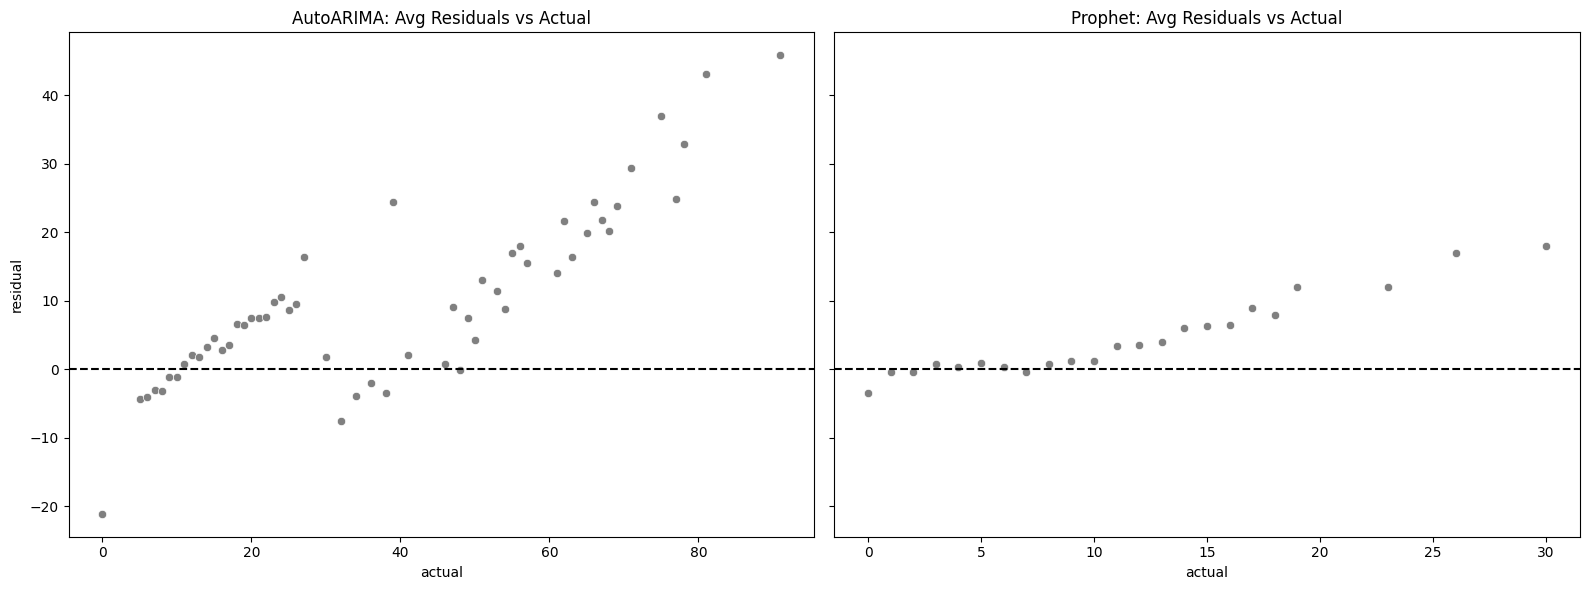

In [26]:
# Combine and Calculate Residuals
df_arima_res = pd.concat(arima_pairs)
df_prophet_res = pd.concat(prophet_pairs)

df_arima_res['residual'] = df_arima_res['actual'] - df_arima_res['pred']
df_prophet_res['residual'] = df_prophet_res['actual'] - df_prophet_res['pred']

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# ARIMA Plot
arima_avg = df_arima_res.groupby('actual')['residual'].mean().reset_index()
sns.scatterplot(data=arima_avg, x='actual', y='residual', color='grey', ax=axes[0])
axes[0].axhline(0, color='black', linestyle='--')
axes[0].set_title('AutoARIMA: Avg Residuals vs Actual')

# Prophet Plot
prophet_avg = df_prophet_res.groupby('actual')['residual'].mean().reset_index()
sns.scatterplot(data=prophet_avg, x='actual', y='residual', color='grey', ax=axes[1])
axes[1].axhline(0, color='black', linestyle='--')
axes[1].set_title('Prophet: Avg Residuals vs Actual')

plt.tight_layout()
plt.show()

### Business questions

In [34]:
# 1. Setup the 1-Month Window
# We assume arima_test and prophet_test already contain the 'last month' of data
results_list = []

# --- 2. AutoARIMA: 1-Month Test ---
for subcat in arima_train['SubcategoryName'].unique():
    s_train = arima_train[arima_train['SubcategoryName'] == subcat].set_index('OrderDate')['OrderQuantity']
    s_test = arima_test[arima_test['SubcategoryName'] == subcat].set_index('OrderDate')['OrderQuantity']
    
    if len(s_test) == 0: continue
    
    # Fit and Predict exactly the length of the test set
    model = auto_arima(s_train, seasonal=True, m=7, suppress_warnings=True)
    preds = model.predict(n_periods=len(s_test))
    
    # Clip and Round for discrete inventory
    preds_final = np.round(np.maximum(preds, 0))
    
    # Use the Daily RMSE from previous eval for Safety Stock calculation
    daily_rmse = arima_results_df.loc[arima_results_df['Subcategory'] == subcat, 'RMSE'].values[0]
    
    results_list.append({
        'SubcategoryName': subcat,
        'Model': 'AutoARIMA',
        'Actual_Month_Sales': int(s_test.sum()),
        'Predicted_Month_Sales': int(preds_final.sum()),
        'Safety_Stock_Level': int(np.round(preds_final.sum() + (1.65 * daily_rmse * np.sqrt(len(s_test)))))
    })

# --- 3. Prophet: 1-Month Test ---
for subcat in prophet_train['SubcategoryName'].unique():
    p_train = prophet_train[prophet_train['SubcategoryName'] == subcat][['OrderDate', 'OrderQuantity']].rename(columns={'OrderDate': 'ds', 'OrderQuantity': 'y'})
    p_test = prophet_test[prophet_test['SubcategoryName'] == subcat][['OrderDate', 'OrderQuantity']].rename(columns={'OrderDate': 'ds', 'OrderQuantity': 'y'})
    
    if p_test.empty: continue
    
    model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=False, weekly_seasonality=True)
    model.fit(p_train)
    
    # Predict exactly the dates in the test set
    forecast = model.predict(p_test[['ds']])
    preds_final = np.round(np.maximum(forecast['yhat'], 0))
    
    daily_rmse = prophet_results_df.loc[prophet_results_df['Subcategory'] == subcat, 'RMSE'].values[0]
    
    results_list.append({
        'SubcategoryName': subcat,
        'Model': 'Prophet',
        'Actual_Month_Sales': int(p_test['y'].sum()),
        'Predicted_Month_Sales': int(preds_final.sum()),
        'Safety_Stock_Level': int(np.round(preds_final.sum() + (1.65 * daily_rmse * np.sqrt(len(p_test)))))
    })

# --- 4. Reporting ---
df_last_month = pd.DataFrame(results_list)

# Calculate Accuracy Metric
df_last_month['Accuracy (%)'] = (1 - (np.abs(df_last_month['Actual_Month_Sales'] - df_last_month['Predicted_Month_Sales']) / 
                                     df_last_month['Actual_Month_Sales'])).clip(0, 1) * 100

display(HTML("<h3>Comparison: Last Month Actuals vs. Predicted</h3>"))
display(df_last_month.sort_values('Actual_Month_Sales', ascending=False))

16:17:40 - cmdstanpy - INFO - Chain [1] start processing
16:17:41 - cmdstanpy - INFO - Chain [1] done processing
16:17:41 - cmdstanpy - INFO - Chain [1] start processing
16:17:41 - cmdstanpy - INFO - Chain [1] done processing
16:17:41 - cmdstanpy - INFO - Chain [1] start processing
16:17:41 - cmdstanpy - INFO - Chain [1] done processing
16:17:41 - cmdstanpy - INFO - Chain [1] start processing
16:17:41 - cmdstanpy - INFO - Chain [1] done processing
16:17:41 - cmdstanpy - INFO - Chain [1] start processing
16:17:41 - cmdstanpy - INFO - Chain [1] done processing
16:17:41 - cmdstanpy - INFO - Chain [1] start processing
16:17:41 - cmdstanpy - INFO - Chain [1] done processing
16:17:41 - cmdstanpy - INFO - Chain [1] start processing
16:17:41 - cmdstanpy - INFO - Chain [1] done processing
16:17:41 - cmdstanpy - INFO - Chain [1] start processing
16:17:41 - cmdstanpy - INFO - Chain [1] done processing
16:17:41 - cmdstanpy - INFO - Chain [1] start processing
16:17:41 - cmdstanpy - INFO - Chain [1]

,SubcategoryName,Model,Actual_Month_Sales,Predicted_Month_Sales,Safety_Stock_Level,Accuracy (%)
5,Tires and Tubes,AutoARIMA,1528,1379,1627,90.248691
3,Bottles and Cages,AutoARIMA,1227,1155,1374,94.132029
4,Helmets,AutoARIMA,517,493,585,95.357834
1,Road Bikes,AutoARIMA,373,331,402,88.739946
2,Caps,AutoARIMA,353,283,354,80.169972
0,Mountain Bikes,AutoARIMA,323,280,339,86.687307
15,Fenders,Prophet,302,327,409,91.721854
8,Jerseys,Prophet,280,256,310,91.428571
6,Touring Bikes,Prophet,210,211,250,99.523810
7,Gloves,Prophet,208,242,297,83.653846


In [35]:
# 1. Setup Horizon (Next 30 Days)
FUTURE_DAYS = 30
future_results = []

# --- 2. AutoARIMA: Future Month ---
for subcat in arima_results_df['Subcategory']:
    # Get full history to retrain for maximum accuracy
    s_full = df_final[df_final['SubcategoryName'] == subcat].set_index('OrderDate')['OrderQuantity']
    last_month_actual = df_last_month.loc[df_last_month['SubcategoryName'] == subcat, 'Actual_Month_Sales'].values[0]
    
    model = auto_arima(s_full, seasonal=True, m=7, suppress_warnings=True)
    future_preds = model.predict(n_periods=FUTURE_DAYS)
    forecast_sum = int(np.round(np.maximum(future_preds, 0).sum()))
    
    # Calculate Safety Stock using the 14.0 RMSE you observed
    daily_rmse = arima_results_df.loc[arima_results_df['Subcategory'] == subcat, 'RMSE'].values[0]
    safe_stock = int(np.round(forecast_sum + (1.65 * daily_rmse * np.sqrt(FUTURE_DAYS))))
    
    future_results.append({
        'SubcategoryName': subcat,
        'Last_Month_Actual': last_month_actual,
        'Future_Forecast': forecast_sum,
        'Safe_Stock_Level': safe_stock
    })

# --- 3. Prophet: Future Month ---
for subcat in prophet_results_df['Subcategory']:
    p_full = df_final[df_final['SubcategoryName'] == subcat][['OrderDate', 'OrderQuantity']].rename(columns={'OrderDate': 'ds', 'OrderQuantity': 'y'})
    last_month_actual = df_last_month.loc[df_last_month['SubcategoryName'] == subcat, 'Actual_Month_Sales'].values[0]
    
    model = Prophet(seasonality_mode='multiplicative', weekly_seasonality=True)
    model.fit(p_full)
    
    future_dates = model.make_future_dataframe(periods=FUTURE_DAYS)
    forecast = model.predict(future_dates)
    forecast_sum = int(np.round(np.maximum(forecast.tail(FUTURE_DAYS)['yhat'], 0).sum()))
    
    daily_rmse = prophet_results_df.loc[prophet_results_df['Subcategory'] == subcat, 'RMSE'].values[0]
    safe_stock = int(np.round(forecast_sum + (1.65 * daily_rmse * np.sqrt(FUTURE_DAYS))))
    
    future_results.append({
        'SubcategoryName': subcat,
        'Last_Month_Actual': last_month_actual,
        'Future_Forecast': forecast_sum,
        'Safe_Stock_Level': safe_stock
    })

# --- 4. Cold Start Floor ---
all_subcats = df_subcat['SubcategoryName'].unique()
active = [r['SubcategoryName'] for r in future_results]
for s in [sc for sc in all_subcats if sc not in active]:
    future_results.append({
        'SubcategoryName': s,
        'Last_Month_Actual': 0,
        'Future_Forecast': 2,
        'Safe_Stock_Level': 5
    })

# --- 5. Status & Styling ---
final_df = pd.DataFrame(future_results)

def inventory_status(row):
    # Risk: If Forecast > Last Month (owner is under-stocking)
    if row['Future_Forecast'] > row['Last_Month_Actual']:
        return f"{int(row['Safe_Stock_Level'])} 🔴 (Risk)"
    # Warning: High volume items regardless of trend
    elif row['Safe_Stock_Level'] > 200:
        return f"{int(row['Safe_Stock_Level'])} ⚠️ (Heavy)"
    return f"{int(row['Safe_Stock_Level'])} 🟢"

display(HTML("<h2>Adventure Works: Next Month Inventory Strategy</h2>"))

styled_output = (final_df.sort_values('Future_Forecast', ascending=False)
                .style.apply(lambda x: ['background-color: #f8d7da' if '🔴' in str(inventory_status(row)) else '' for row in x.index], axis=0) # Incorrect syntax fix:
                .format({'Safe_Stock_Level': lambda x: inventory_status(final_df.loc[final_df['Safe_Stock_Level']==x].iloc[0]) if not final_df.loc[final_df['Safe_Stock_Level']==x].empty else x}))

# Use a simpler formatter for the icons
final_df['Stock_Status'] = final_df.apply(inventory_status, axis=1)

display(final_df[['SubcategoryName', 'Last_Month_Actual', 'Future_Forecast', 'Stock_Status']]
        .sort_values('Future_Forecast', ascending=False)
        .style.hide(axis='index')
        .set_properties(**{'text-align': 'center'}))

16:21:57 - cmdstanpy - INFO - Chain [1] start processing
16:21:57 - cmdstanpy - INFO - Chain [1] done processing
16:21:57 - cmdstanpy - INFO - Chain [1] start processing
16:21:57 - cmdstanpy - INFO - Chain [1] done processing
16:21:57 - cmdstanpy - INFO - Chain [1] start processing
16:21:57 - cmdstanpy - INFO - Chain [1] done processing
16:21:57 - cmdstanpy - INFO - Chain [1] start processing
16:21:57 - cmdstanpy - INFO - Chain [1] done processing
16:21:57 - cmdstanpy - INFO - Chain [1] start processing
16:21:57 - cmdstanpy - INFO - Chain [1] done processing
16:21:57 - cmdstanpy - INFO - Chain [1] start processing
16:21:58 - cmdstanpy - INFO - Chain [1] done processing
16:21:58 - cmdstanpy - INFO - Chain [1] start processing
16:21:58 - cmdstanpy - INFO - Chain [1] done processing
16:21:58 - cmdstanpy - INFO - Chain [1] start processing
16:21:58 - cmdstanpy - INFO - Chain [1] done processing
16:21:58 - cmdstanpy - INFO - Chain [1] start processing
16:21:58 - cmdstanpy - INFO - Chain [1]

SubcategoryName,Last_Month_Actual,Future_Forecast,Stock_Status
Tires and Tubes,1528,1359,1607 ⚠️ (Heavy)
Bottles and Cages,1227,1182,1401 ⚠️ (Heavy)
Helmets,517,473,565 ⚠️ (Heavy)
Road Bikes,373,335,406 ⚠️ (Heavy)
Fenders,302,327,409 🔴 (Risk)
Mountain Bikes,323,305,364 ⚠️ (Heavy)
Caps,353,284,355 ⚠️ (Heavy)
Jerseys,280,270,324 ⚠️ (Heavy)
Gloves,208,241,296 🔴 (Risk)
Touring Bikes,210,224,263 🔴 (Risk)


16:26:50 - cmdstanpy - INFO - Chain [1] start processing
16:26:50 - cmdstanpy - INFO - Chain [1] done processing
16:26:50 - cmdstanpy - INFO - Chain [1] start processing
16:26:50 - cmdstanpy - INFO - Chain [1] done processing
16:26:50 - cmdstanpy - INFO - Chain [1] start processing
16:26:50 - cmdstanpy - INFO - Chain [1] done processing
16:26:50 - cmdstanpy - INFO - Chain [1] start processing
16:26:50 - cmdstanpy - INFO - Chain [1] done processing
16:26:50 - cmdstanpy - INFO - Chain [1] start processing
16:26:50 - cmdstanpy - INFO - Chain [1] done processing
16:26:50 - cmdstanpy - INFO - Chain [1] start processing
16:26:50 - cmdstanpy - INFO - Chain [1] done processing
16:26:50 - cmdstanpy - INFO - Chain [1] start processing
16:26:50 - cmdstanpy - INFO - Chain [1] done processing
16:26:50 - cmdstanpy - INFO - Chain [1] start processing
16:26:50 - cmdstanpy - INFO - Chain [1] done processing
16:26:51 - cmdstanpy - INFO - Chain [1] start processing
16:26:51 - cmdstanpy - INFO - Chain [1]

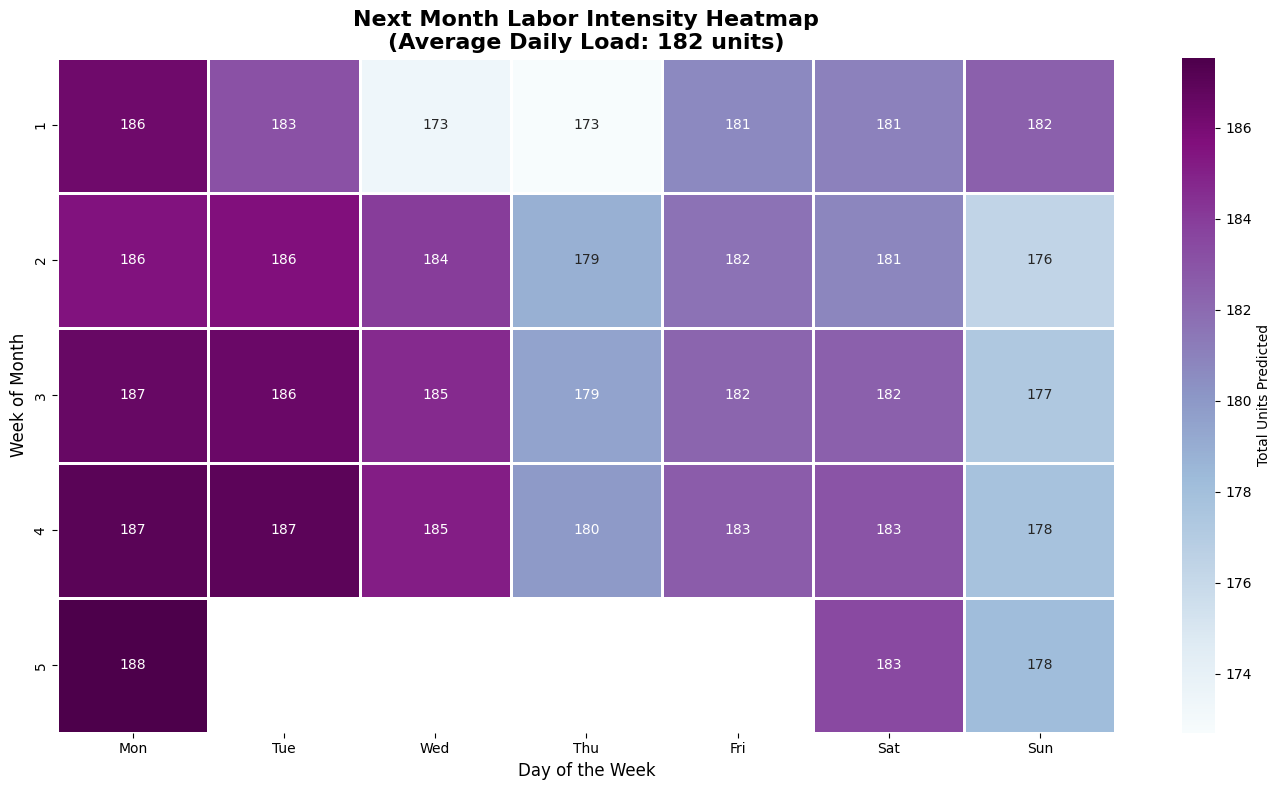

--- ALERT: 0 Days with >20% Above Average Traffic ---
Empty DataFrame
Columns: [OrderDate, Total_Units]
Index: []


In [39]:
# 1. Generate Daily Forecast for the Entire Next Month
# We'll use the next 31 days (assuming March 2026 based on current date)
next_month_dates = pd.date_range(start=df_final['OrderDate'].max() + pd.Timedelta(days=1), periods=31)
daily_predictions = pd.DataFrame({'OrderDate': next_month_dates})
daily_predictions['Total_Units'] = 0.0

# Aggregate predictions from all subcategories
for subcat in arima_train['SubcategoryName'].unique():
    s_full = df_final[df_final['SubcategoryName'] == subcat].set_index('OrderDate')['OrderQuantity']
    model_arima = auto_arima(s_full, seasonal=True, m=7, suppress_warnings=True)
    daily_predictions['Total_Units'] += model_arima.predict(n_periods=31).values

for subcat in prophet_train['SubcategoryName'].unique():
    p_full = df_final[df_final['SubcategoryName'] == subcat][['OrderDate', 'OrderQuantity']].rename(columns={'OrderDate': 'ds', 'OrderQuantity': 'y'})
    model_prophet = Prophet(seasonality_mode='multiplicative', weekly_seasonality=True)
    model_prophet.fit(p_full)
    future = model_prophet.make_future_dataframe(periods=31, include_history=False)
    forecast = model_prophet.predict(future)
    daily_predictions['Total_Units'] += forecast['yhat'].values

# 2. Prepare Calendar Structure
calendar_df = daily_predictions.copy()
calendar_df['Day'] = calendar_df['OrderDate'].dt.day
calendar_df['Day_of_Week_Num'] = calendar_df['OrderDate'].dt.dayofweek # 0=Mon, 6=Sun
calendar_df['Week_of_Month'] = (calendar_df['Day'] - 1) // 7 + 1

# 3. Pivot for Heatmap
pivot_cal = calendar_df.pivot(index='Week_of_Month', columns='Day_of_Week_Num', values='Total_Units')

# 4. Labeling and Aesthetics
days_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
# Fill missing days (if month starts mid-week) with 0 or NaN
pivot_cal.columns = [days_labels[i] for i in pivot_cal.columns]

# Calculate the Average to find "High Traffic"
avg_daily_load = calendar_df['Total_Units'].mean()

# 5. Visualization
plt.figure(figsize=(14, 8))
sns.heatmap(
    pivot_cal, 
    cmap='BuPu', # Yellow to Red highlights heat/risk better
    annot=True, 
    fmt=".0f", 
    linewidths=2,
    cbar_kws={'label': 'Total Units Predicted'}
)

plt.title(f"Next Month Labor Intensity Heatmap\n(Average Daily Load: {avg_daily_load:.0f} units)", fontweight='bold', fontsize=16)
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Week of Month", fontsize=12)
plt.tight_layout()
plt.show()

# 6. Print High Traffic Alerts
high_days = calendar_df[calendar_df['Total_Units'] > avg_daily_load * 1.2]
print(f"--- ALERT: {len(high_days)} Days with >20% Above Average Traffic ---")
print(high_days[['OrderDate', 'Total_Units']].to_string(index=False))

In [37]:
# 1. Reuse the final_df from the previous step
# It already contains 'Last_Month_Actual' and 'Future_Forecast'
growth_df = final_df.copy()

# 2. Calculate Month-over-Month (MoM) Growth Percentage
# Using .replace(0, 1) to avoid division by zero for new/cold items
growth_df['mom_growth_pct'] = ((growth_df['Future_Forecast'] - growth_df['Last_Month_Actual']) / 
                               growth_df['Last_Month_Actual'].replace(0, 1)) * 100

# 3. Categorization Logic
def categorize_momentum(val):
    if val > 5:
        return '🟢 Increase'
    elif val < -5:
        return '🔴 Decrease'
    else:
        return '🟡 Stagnant'

growth_df['Trend'] = growth_df['mom_growth_pct'].apply(categorize_momentum)

# 4. Final Strategic Dashboard
display(HTML("<h3>Market Momentum: Next Month Forecast vs. Last Month Actuals</h3>"))

# Sort by growth percentage to show booming items at the top
styled_momentum = (growth_df[['SubcategoryName', 'Last_Month_Actual', 'Future_Forecast', 'mom_growth_pct', 'Trend']]
                   .sort_values('mom_growth_pct', ascending=False)
                   .style.format({
                       'mom_growth_pct': '{:.1f}%',
                       'Last_Month_Actual': '{:,.0f}',
                       'Future_Forecast': '{:,.0f}'
                   })
                   .set_properties(**{'text-align': 'center'})
                   .hide(axis='index'))

display(styled_momentum)

SubcategoryName,Last_Month_Actual,Future_Forecast,mom_growth_pct,Trend
Tights,0,2,200.0%,🟢 Increase
Chains,0,2,200.0%,🟢 Increase
Brakes,0,2,200.0%,🟢 Increase
Bottom Brackets,0,2,200.0%,🟢 Increase
Handlebars,0,2,200.0%,🟢 Increase
Lights,0,2,200.0%,🟢 Increase
Locks,0,2,200.0%,🟢 Increase
Panniers,0,2,200.0%,🟢 Increase
Pumps,0,2,200.0%,🟢 Increase
Headsets,0,2,200.0%,🟢 Increase


In [40]:
# 1. Identify the Time Windows
first_date = df_final['OrderDate'].min()
last_date = df_final['OrderDate'].max()

# 2. Extract Data for the First Month
first_month_mask = (df_final['OrderDate'].dt.year == first_date.year) & \
                   (df_final['OrderDate'].dt.month == first_date.month)
first_month_total = df_final[first_month_mask]['OrderQuantity'].sum()

# 3. Extract Data for the Last Month (Historical)
last_month_mask = (df_final['OrderDate'].dt.year == last_date.year) & \
                  (df_final['OrderDate'].dt.month == last_date.month)
last_month_total = df_final[last_month_mask]['OrderQuantity'].sum()

# 4. Calculate Lifetime Growth
lifetime_growth = ((last_month_total - first_month_total) / first_month_total * 100) if first_month_total > 0 else 0

# 5. Dashboard Update
lifecycle_metrics = pd.DataFrame({
    'Lifecycle Metric': [
        f'Inception Month ({first_date.strftime("%b %Y")}) Total Units',
        f'Current Month ({last_date.strftime("%b %Y")}) Total Units',
        'Total Lifetime Growth (Start to Now)'
    ],
    'Value': [
        f"{int(first_month_total):,}",
        f"{int(last_month_total):,}",
        f"{lifetime_growth:+.2f}%"
    ]
})

display(HTML("<h2 style='color:#008080;'>Business Lifecycle: Inception vs. Current</h2>"))
display(lifecycle_metrics.style.set_properties(**{'text-align': 'left', 'padding': '12px'})
        .set_table_styles([{'selector': 'th', 'props': [('background-color', '#008080'), ('color', 'white')]}])
        .hide(axis='index'))

Lifecycle Metric,Value
Inception Month (Aug 2016) Total Units,"4,344"
Current Month (Jun 2017) Total Units,"5,770"
Total Lifetime Growth (Start to Now),+32.83%
